# Import Libraries 

In [1]:
import os
import numpy as np
from numpy import save, asarray
from matplotlib import pyplot as plt
%matplotlib inline

import pickle as pkl
import tensorflow as tf

from keras.datasets import cifar10
from tensorflow import keras
from keras.utils import np_utils
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, InputLayer, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

## Functions

In [2]:
## Load data using pickle
def unloadPickle(file):
    with open(file, 'rb') as f:
        temp =  pkl.load(f, encoding='latin1')
    return temp

## Extract train and test data and reshape images to (32, 32, 3)
def extractData(dataPath, dataStr):
    
    if dataStr == '\data_batch_':
        X_train = []
        y_train = []

        for i in range(1, 6):
            filePath = dataPath + dataStr + str(i)
            file = unloadPickle(filePath)
            file['data'] = file['data'].reshape((len(file['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
            X_train.append(file['data'])
            y_train.append(file['labels'])
            
        metaFile = unloadPickle(os.path.join(dataPath,'batches.meta'))
        labelNames = metaFile['label_names']
        
        return X_train, y_train, labelNames
    
    elif dataStr == 'test_batch':    
        
        filePath = os.path.join(dataPath, dataStr)
        file = unloadPickle(filePath)
        file['data'] = file['data'].reshape((len(file['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
        X_test = file['data']
        y_test = file['labels']
    
        return X_test, y_test

## Display the statistics of the data and display the image based on the batch and sample image    
def displayStats(dataPath, dataStr, batch_id, sample_id):
    
    X, y, labelNames = extractData(dataPath, dataStr)
    
    features = []
    labels = []
    
    print('No. of batches : {}'.format(len(X)))
    print('No. of samples in each batch : {}'.format(len(X[batch_id])))
    print('Shape of each sample : {}'.format(X[batch_id - 1][sample_id].shape))
    print('\nStats of batch {}'.format(batch_id))
    print('\nCount of each label in batch {} : '.format(batch_id))
    
    label_counts = dict(zip(*np.unique(y[batch_id - 1], return_counts=True)))
    
    for key, value in label_counts.items():
        print('No. of {} images : {}'.format((labelNames[key]).upper(), value))
    
    sample_label = y[batch_id - 1][sample_id]
    print('\nSample Id : {}, Image name : {}'.format(sample_id, (labelNames[sample_label]).upper()))
    sample_image = X[batch_id - 1][sample_id]
    plt.imshow(sample_image)

## One hot encode the labels
def oneHotEncode(labels):
    
    x = np.zeros((len(labels), 10))
    for i, j in enumerate(labels):
        x[i][j] = 1
    
    return x

## Cannot use this function as it is returning binary values instead of values between 0 to 1
## Normalize the image
# def normImage(image):
    
#     image = image.astype('float32')   
#     image /= 255
    
#     return image

## Perform the pre-processing steps
# def preprocessData(X, y):
               
#     for j, img in enumerate(X):
#         img = img.astype('float32')
#         img /= 255
#         X[j] = img
#         #X[j] = tf.random_crop()
        
#     y = oneHotEncode(y)
            
#     return X, y

## Dump the train or test data in pickle files
def saveData(batch_features, batch_labels, filename):
    
    pkl.dump((batch_features, batch_labels), open(filename, 'wb'))
    
def schedulerLr(epoch, lr):
    if epoch < lr:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Load Dataset 

In [3]:
os.chdir("../..")
dataPath = os.path.join(os.getcwd(), 'ImageClassification\\archive\cifar-10-batches-py')
print(dataPath)

D:\Competetions\Kaggle\ImageClassification\archive\cifar-10-batches-py


No. of batches : 5
No. of samples in each batch : 10000
Shape of each sample : (32, 32, 3)

Stats of batch 1

Count of each label in batch 1 : 
No. of AIRPLANE images : 1005
No. of AUTOMOBILE images : 974
No. of BIRD images : 1032
No. of CAT images : 1016
No. of DEER images : 999
No. of DOG images : 937
No. of FROG images : 1030
No. of HORSE images : 1001
No. of SHIP images : 1025
No. of TRUCK images : 981

Sample Id : 123, Image name : BIRD


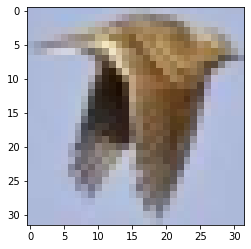

In [4]:
trainStr = '\data_batch_'
testStr = 'test_batch'

displayStats(dataPath, trainStr, 1, 123)

In [15]:
feat, lbl, labelNames = extractData(dataPath, trainStr)

# Pre-processing

In [16]:
batch_ids = [1, 2, 3, 4, 5]
train_feat, train_lbl = [], []
for b_id in batch_ids:
    temp_batch = []
    for idx, img in enumerate(feat[i-1]):
        temp_batch.append(feat[b_id-1][idx] / 255.0)
    train_feat.append(asarray(temp_batch)) 
    train_lbl.append(oneHotEncode(lbl[b_id-1]))
    
    saveData(train_feat[b_id-1], train_lbl[b_id-1], os.path.join(dataPath, 'prcsd_batch_' + str(b_id) + '.pkl'))

In [7]:
X, y = extractData(dataPath, testStr)
X_test, y_test = [], []
for idx, img in enumerate(X):
    X[idx] = X[idx].astype('float32')
    X_test.append(X[idx] / 255.0)

X_test = asarray(X_test)    
y_test = oneHotEncode(y)
saveData(X_test, y_test, os.path.join(dataPath, 'prcsd_test_batch.pkl'))

# Model Generation

In [14]:
train_features = []
train_labels = []
batch_ids = [1, 2, 3, 4, 5]
for b_id in batch_ids:
    path = os.path.join(dataPath, 'prcsd_batch_' + str(b_id) + '.pkl')
    temp_batch = unloadPickle(path)
    train_features.append(temp_batch[0]) 
    train_labels.append(temp_batch[1])

In [15]:
X_train_features, y_train_labels = np.concatenate(train_features, axis = 0), np.concatenate(train_labels, axis = 0)

In [ ]:
# test_path = os.path.join(dataPath, 'test_batch.pkl')
# X_test, y_test = unloadPickle(test_path)

In [19]:
X_train, X_train_val, y_train, y_train_val = train_test_split(X_train_features, 
                                                                  y_train_labels, 
                                                                  test_size=0.2, 
                                                                  random_state=42)

In [20]:
def cnnModel(feature_shape, labels, learning_rate):
    
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(4, 4), input_shape=feature_shape, activation='relu'))
    model.add(MaxPool2D(2, 2))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(labels, activation='softmax'))
    
    opt = Adam(learning_rate)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def metrics_graph(model, num_epoch):
    
    r_ep = range(num_epoch)
    train_loss = model.history['loss']
    validation_loss = model.history['val_loss']
    train_acuracy = model.history['accuracy']
    validation_accuracy = model.history['val_accuracy']

    plt.figure(figsize=(15,7))
    
    plt.subplot(1, 2, 1)
    plt.title('Train vs Validation')
    plt.plot(r_ep, train_loss)
    plt.plot(r_ep, validation_loss)
    plt.legend(['train_loss', 'val_loss'])
    plt.xlabel('No. of epochs')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.title('Train Accuracy vs Validation Accuracy')
    plt.plot(r_ep, train_acuracy)
    plt.plot(r_ep, validation_accuracy)
    plt.legend(['train_acc', 'val_acc'])
    plt.xlabel('No. of epochs')
    plt.ylabel('Accuracy')

In [21]:
callback = tf.keras.callbacks.LearningRateScheduler(schedulerLr)

In [22]:
feature_shape = X_train_features[0].shape
labels = len(y_train_labels[0])
#dropout_rate = 0.25
num_epoch = 30
learning_rate = 0.001
decay_rate = learning_rate / num_epoch
momentum = 0.8

model = cnnModel(feature_shape, labels, learning_rate)
#model.summary()
cnn_model = model.fit(X_train_features, y_train_labels, 
                          epochs = num_epoch, 
                          batch_size = 32, 
                          callbacks=[callback],
                          validation_data=(X_train_val, y_train_val))

Epoch 1/30
1563/1563 [==============================] - 65s 41ms/step - loss: 1.4887 - accuracy: 0.4681 - val_loss: 1.2135 - val_accuracy: 0.5772 - lr: 0.0010
Epoch 2/30
1563/1563 [==============================] - 52s 33ms/step - loss: 1.1657 - accuracy: 0.5898 - val_loss: 1.0171 - val_accuracy: 0.6480 - lr: 9.0484e-04
Epoch 3/30
1563/1563 [==============================] - 37s 24ms/step - loss: 1.0492 - accuracy: 0.6306 - val_loss: 0.9478 - val_accuracy: 0.6757 - lr: 8.1873e-04
Epoch 4/30
1563/1563 [==============================] - 9s 6ms/step - loss: 0.9749 - accuracy: 0.6584 - val_loss: 0.9085 - val_accuracy: 0.6853 - lr: 7.4082e-04
Epoch 5/30
1563/1563 [==============================] - 46s 29ms/step - loss: 0.9191 - accuracy: 0.6806 - val_loss: 0.8507 - val_accuracy: 0.7014 - lr: 6.7032e-04
Epoch 6/30
1563/1563 [==============================] - 65s 41ms/step - loss: 0.8702 - accuracy: 0.6981 - val_loss: 0.8090 - val_accuracy: 0.7234 - lr: 6.0653e-04
Epoch 7/30
1563/1563 [======

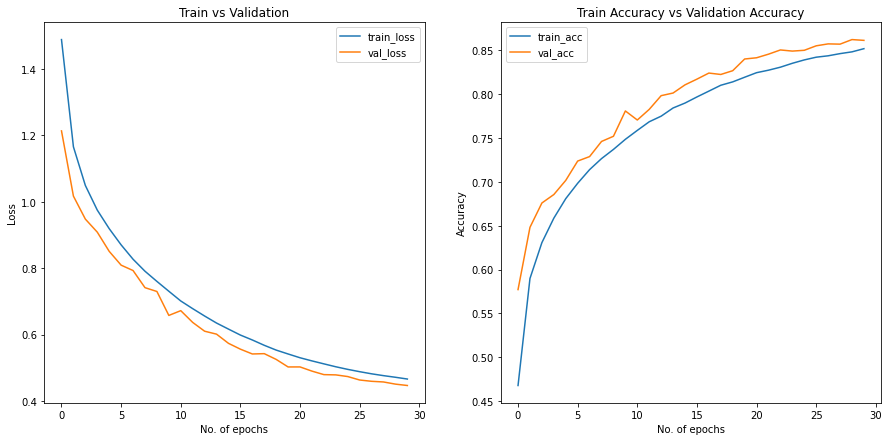

In [23]:
metrics_graph(cnn_model, num_epoch)

In [ ]:
metrics_graph(cnn_model, num_epoch)